# Sheet Data

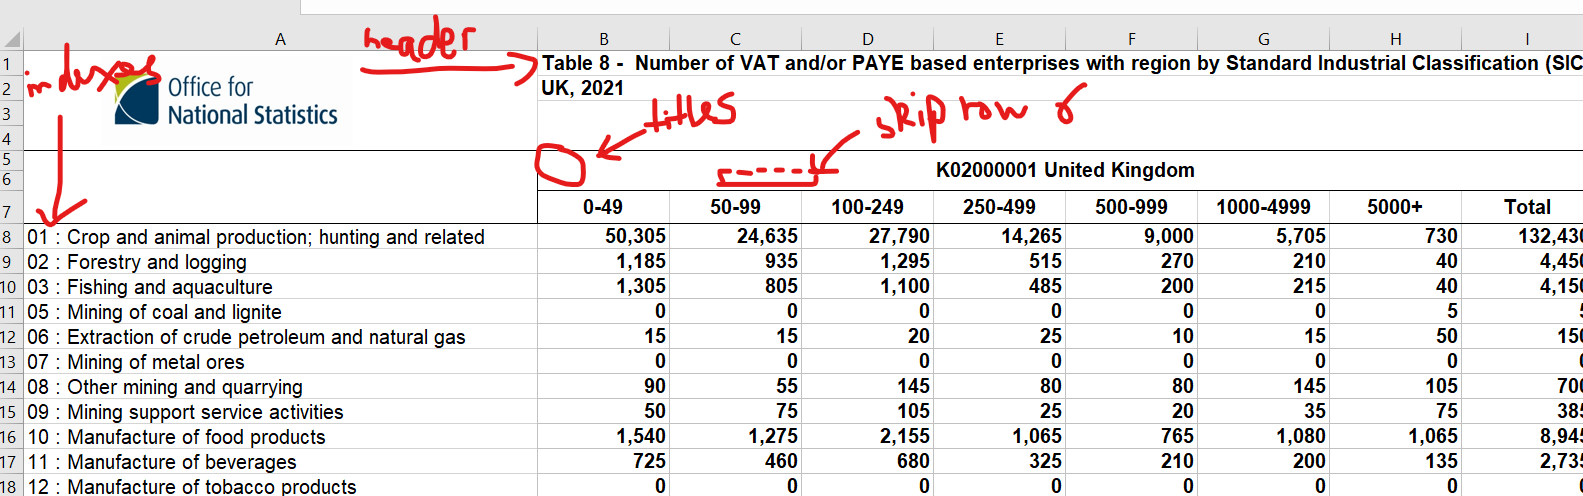

In [1]:
from typing import TypedDict, List, NamedTuple, Union, Literal
import pandas as pd
from openpyxl.worksheet.worksheet import Worksheet
import openpyxl
from tqdm import tqdm
import re

class SheetInfo(TypedDict):
    """get title and coordinates of table data from business unit workbook sheet"""
    title: str
    subtitle: str
    title_rows: List[int]
    index_cols: List[int]

class SearchException(Exception):
    pass

class Cell(TypedDict):
    row: int
    col: int

Direction = Union[Literal["across"], Literal["down"]]
             
def traverse_to_value(ws: Worksheet, start_cell: Cell, direction: Direction, stop_search: int = 10000) -> Cell:
    """
    move from a starting cell across or down in a worksheet until a non-empty cell is found and its coordinates returned
    exception thrown if iteration passes `stop_search` count
    """
    cell = start_cell.copy()
    for i in range(stop_search):
        if direction == 'across':
            cell['col'] += 1
        else:
            cell['row'] += 1
        if ws.cell(row=cell['row'], column=cell['col']).value is not None:
            return cell
    raise SearchException

def row_empty(row: List) -> bool:
    """
    detect if a row of cells is empty
    """
    return all(c.value is None for c in row)

def get_sheet_info(ws: Worksheet) -> SheetInfo:
    # get cell containing header
    header_cell = traverse_to_value(ws, Cell(row=1, col=1), "across")
    # get first cell containing column titles, below header and subheader
    titles_cell = traverse_to_value(ws, Cell(row=header_cell["row"] + 2, col=header_cell["col"]), "down")
    # get first cell with index values
    indexes_cell = traverse_to_value(ws, Cell(row=1, col=1), "down")
    title_rows = [r for r in range(titles_cell["row"], indexes_cell["row"]) if not row_empty(ws[r])]
    
    return {
        'title': ws.cell(
            header_cell["row"], 
            header_cell["col"]
        ).value,
        'subtitle': ws.cell(
            header_cell["row"] + 1, 
            header_cell["col"]
        ).value,
        'title_rows': title_rows,
        'index_cols': [i for i in range(1, header_cell["col"])],
    }

In [2]:
wb = openpyxl.load_workbook('excel-files/ukbusinessworkbook2021.xlsx')

In [3]:
sh8=get_sheet_info(wb["Table 8"])
sh8

{'title': "Table 8 -  Number of VAT and/or PAYE based enterprises with region by Standard Industrial Classification (SIC) class and turnover sizebands (£000's)",
 'subtitle': 'UK, 2021',
 'title_rows': [5, 7],
 'index_cols': [1]}

In [4]:
def get_df(shnm, info):
    df = pd.read_excel(
        'excel-files/ukbusinessworkbook2021.xlsx', 
        sheet_name=shnm,
        header=[row-1 for row in info['title_rows']],
        index_col=[col-1 for col in info['index_cols']]
    )
    
    total_cols = df.filter(like='Total', axis=1).columns
    df = df.drop(total_cols, axis=1)
    
    total_rows = df.filter(like='Total', axis=0).index
    df = df.drop(total_rows, axis=0)
    
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()
    
    return df

In [5]:
df1 = get_df('Table 1', get_sheet_info(wb['Table 1']))
df2 = df1.copy()
dfflat = pd.melt(df2, ignore_index=False)
dfflat['variable_x'] = dfflat.index.get_level_values(level=0)
dfflat

,,variable_0,variable_1,value,variable_x
K02000001,UNITED KINGDOM,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",141030.0,K02000001
K03000001,GREAT BRITAIN,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",122820.0,K03000001
K04000001,ENGLAND AND WALES,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",105575.0,K04000001
E92000001,ENGLAND,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",91905.0,E92000001
E12000001,NORTH EAST,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",3795.0,E12000001
...,...,...,...,...,...
N09000006,Fermanagh and Omagh,Broad Industry Group,"90-99 : Arts, entertainment, recreation & othe...",300.0,N09000006
N09000007,Lisburn and Castlereagh,Broad Industry Group,"90-99 : Arts, entertainment, recreation & othe...",385.0,N09000007
N09000008,Mid and East Antrim,Broad Industry Group,"90-99 : Arts, entertainment, recreation & othe...",340.0,N09000008
N09000009,Mid Ulster,Broad Industry Group,"90-99 : Arts, entertainment, recreation & othe...",315.0,N09000009


In [6]:
import re

In [7]:
m=re.match('^Table (\d+)', 'Table 132')
m

<re.Match object; span=(0, 9), match='Table 132'>

In [8]:
m.group(1)

'132'

In [9]:
dftest = pd.DataFrame({'a':[1,2], 'b':['pls', 4]})
dftest.apply(pd.to_numeric, errors='coerce')

,a,b
0,1,NaN
1,2,4.0


In [10]:
import re
from tqdm import tqdm
dfs = []
tables = {}
for shnm in tqdm(wb.sheetnames):
    match = re.match('^Table (\d+)', shnm) 
    if match:
        table_index = int(match.group(1))
        sh_info = get_sheet_info(wb[shnm])
        df = get_df(shnm, sh_info)
        df = pd.melt(df, ignore_index=False, var_name=[f'variable_{x}' for x in range(df.columns.nlevels)])
        df['variable_x'] = df.index.get_level_values(level=0)
        df['table'] = table_index
        dfs.append(df)
        tables[table_index] = sh_info
wbdfin = pd.concat(dfs)
wbdf = wbdfin.reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.94it/s]


In [11]:
dftables = pd.DataFrame.from_dict(tables, orient='index')
dftables = dftables.drop(['title_rows', 'index_cols'], axis=1)
dftables

,title,subtitle
1,Table 1 - Number of VAT and/or PAYE based ente...,"UK, 2021"
2,Table 2 - Number of VAT and/or PAYE based ent...,"UK, 2021"
3,Table 3 - Number of VAT and/or PAYE based ent...,"UK, 2021"
4,Table 4 - Number of VAT and/or PAYE based ente...,"UK, 2021"
5,Table 5 - Number of VAT and/or PAYE based ent...,"UK, 2021"
6,Table 6 - Number of VAT and/or PAYE based ent...,"UK, 2021"
7,Table 7 - Number of VAT and/or PAYE based ent...,"UK, 2021"
8,Table 8 - Number of VAT and/or PAYE based ent...,"UK, 2021"
9,Table 9 - Number of VAT and/or PAYE based ent...,"UK, 2021"
10,Table 10 - Number of VAT and/or PAYE based ent...,"UK, 2021"


In [12]:
wbdf['value'] = wbdf['value'].astype(int)

In [13]:
wbdf

,variable_0,variable_1,value,variable_x,table
0,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",141030,K02000001,1
1,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",122820,K03000001,1
2,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",105575,K04000001,1
3,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",91905,E92000001,1
4,Broad Industry Group,"01-03 : Agriculture, forestry & fishing",3795,E12000001,1
...,...,...,...,...,...
133719,Years,2021,230220,Business administration and support services,28
133720,Years,2021,7695,Public administration and defence; compulsory ...,28
133721,Years,2021,45495,Education,28
133722,Years,2021,104550,Health,28


# Database

try writing dataframe to a test sqlite database

In [31]:
import pandas as pd
df = pd.DataFrame({'a': ['a', 'b'], 'idx': ['x', 'y']})

In [33]:
import sqlite3
with sqlite3.connect('test.db') as con:
    df.to_sql('users', con=con, if_exists='replace', dtype={'idx': 'TEXT PRIMARY KEY'})

now write for real

In [37]:
with sqlite3.connect('businessdatabase2.db') as con:
    wbdf.to_sql('tabledata', con=con, if_exists='replace', dtype={'index_label': 'INTEGER PRIMARY KEY'})
    dftables.to_sql('tableinfo', con=con, if_exists='replace', dtype={'index_label': 'TEXT PRIMARY KEY'})